In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model
from shutil import copyfile, rmtree
from timeit import default_timer as timer

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
pip install "tensorflow<2.11" 

Could not fetch URL https://pypi.org/simple/tensorflow/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/tensorflow/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)'))) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow<2.11 (from versions: none)
ERROR: No matching distribution found for tensorflow<2.11


In [5]:
INPUT_ROOT = "ML - 2"
def from_input(path):
    return os.path.join(INPUT_ROOT, path)

In [6]:
train_info = pd.read_csv(from_input("Train.csv"))
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [7]:
train_info.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [8]:
train_info.groupby('ClassId')['ClassId'].count()

ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: ClassId, dtype: int64

In [12]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Показываем изображения в сетке 6х8.
nrows = 8
ncols = 6

pic_offset = 0 # Чтобы итерировать по изображениям каждый раз когда запустим код ниже.

In [13]:
def show_images(offset):
    fig = plt.gcf()
    fig.set_size_inches(ncols*3, nrows*3)

    for i in range(43):
        # subplot индексы начинаются с 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off')
        subdir = os.path.join(from_input('train'), str(i))
        files = os.listdir(subdir)
        img_path = os.path.join(subdir, files[offset % len(files)])
        img = mpimg.imread(img_path)
        #print(img.shape)
        plt.imshow(img)

    plt.show()

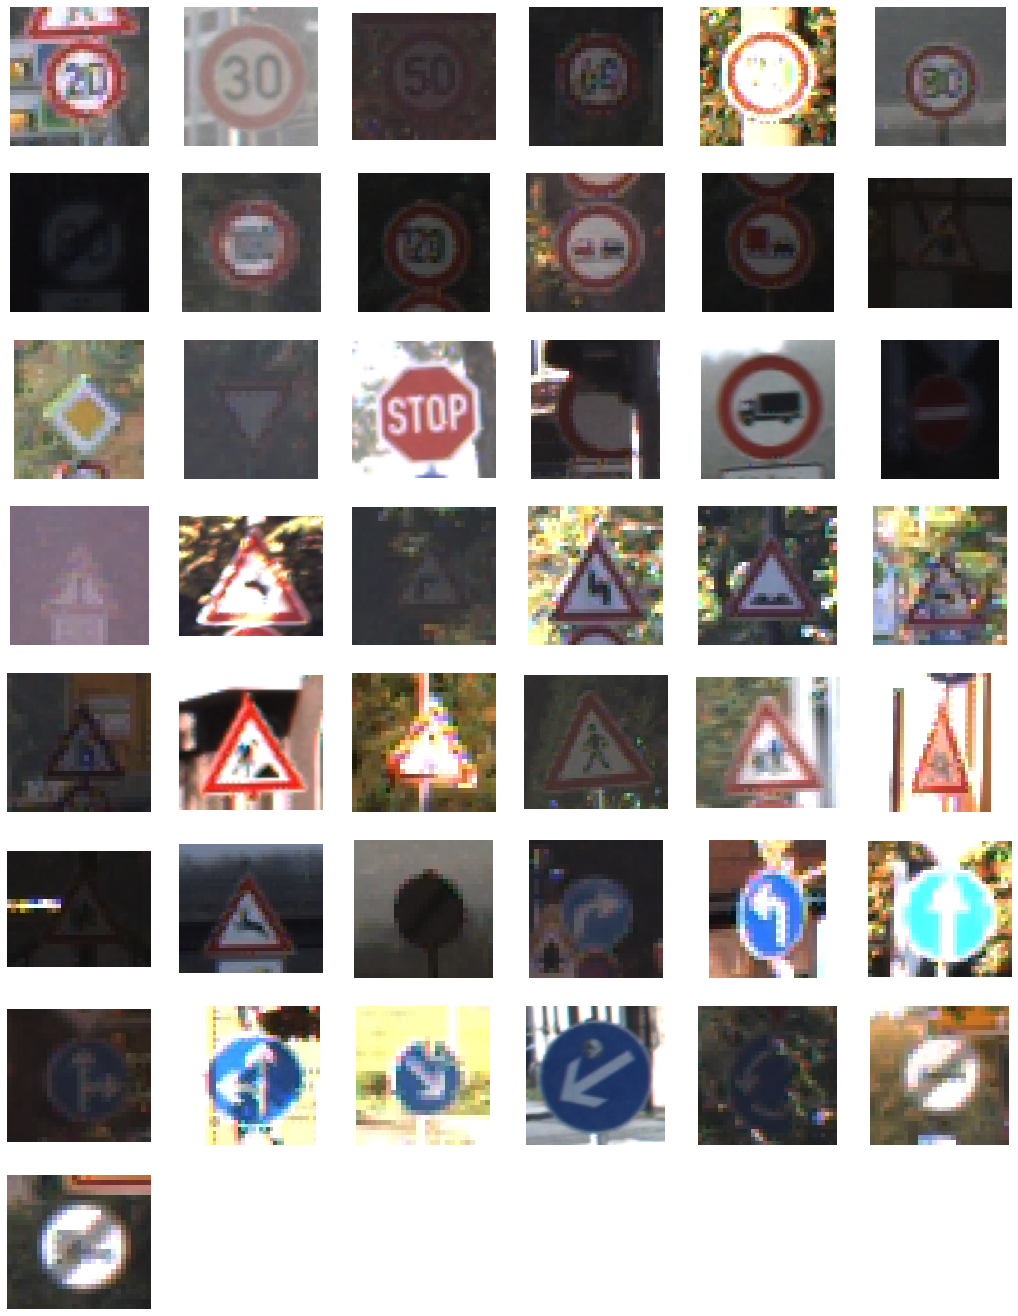

In [15]:
show_images(pic_offset)
pic_offset += 1

In [16]:
TARGET_SIZE = (40, 40) # изображения будут изменены до этого размера
FLATTEN_SIZE = TARGET_SIZE[0] * TARGET_SIZE[1] * 3
BATCH_SIZE=300

In [17]:
TCH_SIZE=300
paths = train_info['Path'].values
y_train = train_info['ClassId'].values

indices = np.arange(y_train.shape[0])
randgen = random.Random(62)
randgen.shuffle(indices)

paths = paths[indices]
y_train = y_train[indices]
y_train = to_categorical(y_train, 43)

train_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('train'), f.replace('Train/', '')), target_size=TARGET_SIZE)
    train_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [18]:
X_train = tf.keras.applications.vgg16.preprocess_input(np.array(train_data))
train_data = None

In [19]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

train_aug_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       rotation_range = 18,
                                       width_shift_range = 0.18,
                                       height_shift_range = 0.18,
                                       shear_range = 0.18,
                                       zoom_range = 0.18,
                                       horizontal_flip = False)

train_aug_generator = train_datagen.flow(X_train,
                                    y_train,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    seed=17)

In [20]:
paths = test_info['Path'].values
y_test = test_info['ClassId'].values
y_test = to_categorical(y_test, 43)

test_data=[]

for i, f in enumerate(paths):
    print('\rLoading data {0:.1f}%...'.format((i / len(paths)) * 100), end = '\r')
    image = load_img(os.path.join(from_input('test'), f.replace('Test/', '')), target_size=TARGET_SIZE)
    test_data.append(img_to_array(image))

print('Data loaded.              ')

Data loaded.              


In [21]:
X_test = tf.keras.applications.vgg16.preprocess_input(np.array(test_data))
test_data = None

In [22]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow(X_test,
                                    y_test,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    seed=17)

In [23]:
def plot(history, plot_acc = True):
    %matplotlib inline

    import matplotlib.image  as mpimg
    import matplotlib.pyplot as plt

    
    loss=history.history['loss']
    epochs=range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'r', "Training Loss")
    plt.xlabel('Epoch')
    plt.title('Training loss')
    # validation
    plt.plot(epochs, history.history['val_loss'], 'b', "Validation Loss")

    if plot_acc:
        acc=history.history['acc']
        plt.figure()
        plt.plot(epochs, acc, 'r', "Training Accuracy")
        plt.title('Training accuracy')
        plt.xlabel('Epoch')
        plt.plot(epochs, history.history['val_acc'], 'b', "Validation Accuracy")

In [24]:
def show_layers(model):
    print('Name\tOutput shape\tActivation\tInitializer')
    for l in model.layers:
        print('{0}({1})\t{2}\t{3}\t{4}'
            .format(l.name,
              l.__class__.__name__,
              l.output_shape,
              l.activation.__name__ if hasattr(l, 'activation') else '<none>',
              l.kernel_initializer.__class__.__name__ if hasattr(l, 'kernel_initializer') else '<none>'))


def custom_summary(model):
    model.summary()
    show_layers(model)

In [25]:
VERBOSE=1

In [26]:
def train_model(model, optimizer, epochs, train_generator):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = timer()
    history = model.fit_generator(train_generator,
                        epochs=epochs,
                        verbose=VERBOSE,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=2)],
                        validation_data=test_generator,
                        steps_per_epoch= round(X_train.shape[0] / BATCH_SIZE))
    end_time = timer()
    
    print('==============================')
    print('Optimizer: ', optimizer.__class__.__name__)
    print('Learning rate: ', optimizer.get_config()['learning_rate'])
    print('Epochs: ', epochs)
    print('==============================')
    print('Trained in {0:.2f} minutes'.format((end_time - start_time) / 60))
    
    acc=history.history['acc'][-1]
    test_acc = model.evaluate_generator(test_generator)[1]
    
    print('Results at the end of training: acc={1:.02f}%, test_acc={2:.02f}%'
          .format(i, acc*100, test_acc*100))

    plot(history)

In [27]:
def get_classificator_model(base_model, last_output):
    x = Flatten()(last_output)
    x = Dropout(0.33)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.33)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(43, activation='softmax')(x)           

    model = Model(base_model.input, x)
    return model

In [28]:
IMG_SHAPE = TARGET_SIZE + (3,)
pretrained_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 20, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 20, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 20, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 10, 10, 128)       0     

In [29]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [1]:
last_layer = pretrained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

optimizer=Adam(learning_rate=0.0001)
epochs=50
train_model(get_classificator_model(pretrained_model, last_output), optimizer, epochs, train_generator)

NameError: name 'pretrained_model' is not defined